# Cluster Overview
The purpose of this notebook is to look and generate any plots needed in the paper.  The purpose of each cell is explained above with a markdown.  Each must be run in succession in case of reusing variables

### Load the DataSet

In [26]:
# Cell loads the data

from Functions import data_loader, get_descriptors, one_filter, data_scaler
import os, sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
from sklearn import preprocessing
from sklearn.cluster import KMeans
from Functions import make_pca_agg_fit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )
X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
# removes catagorical varaiables
test=data.drop(["MOF ID","topology","First nodular character","Second nodular character"],axis=1)
#g_comp=5
# all vs just used !!!! uncomment below for just feature used anaylsis
g_comp=6
test=test[['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']]
g=preprocessing.StandardScaler().fit_transform(test)
g=pd.DataFrame(g)
g.columns=test.columns
test=g

### Generated pca plot of predictive features

[-0.53440042] [7.89361159]
[-0.0671099] [2.09788303]


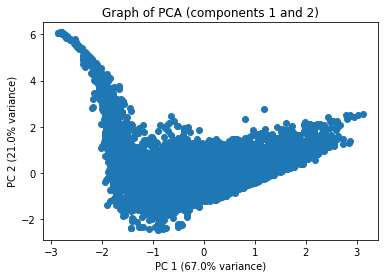

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew
var=.9
_,_,color=make_pca_agg_fit(1,test,var,g_comp,func_give=KMeans,array_out=True)
Out=PCA(n_components=2)
f=Out.fit(test)
a=f.transform(test)
pc1=a.T[:][0]
pc2=a.T[:][1]
pc1=StandardScaler().fit_transform(pc1.reshape(-1, 1))
pc2=StandardScaler().fit_transform(pc2.reshape(-1, 1))
print(kurtosis(pc1),kurtosis(pc2))
print(skew(pc1),skew(pc2))
plt.scatter(pc1,pc2)
plt.title("Graph of PCA (components 1 and 2)")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
plt.savefig("PCA Graph.png",dpi=400)
plt.show()

### Generated generic cluster plot with bisect to see component importance in PCA

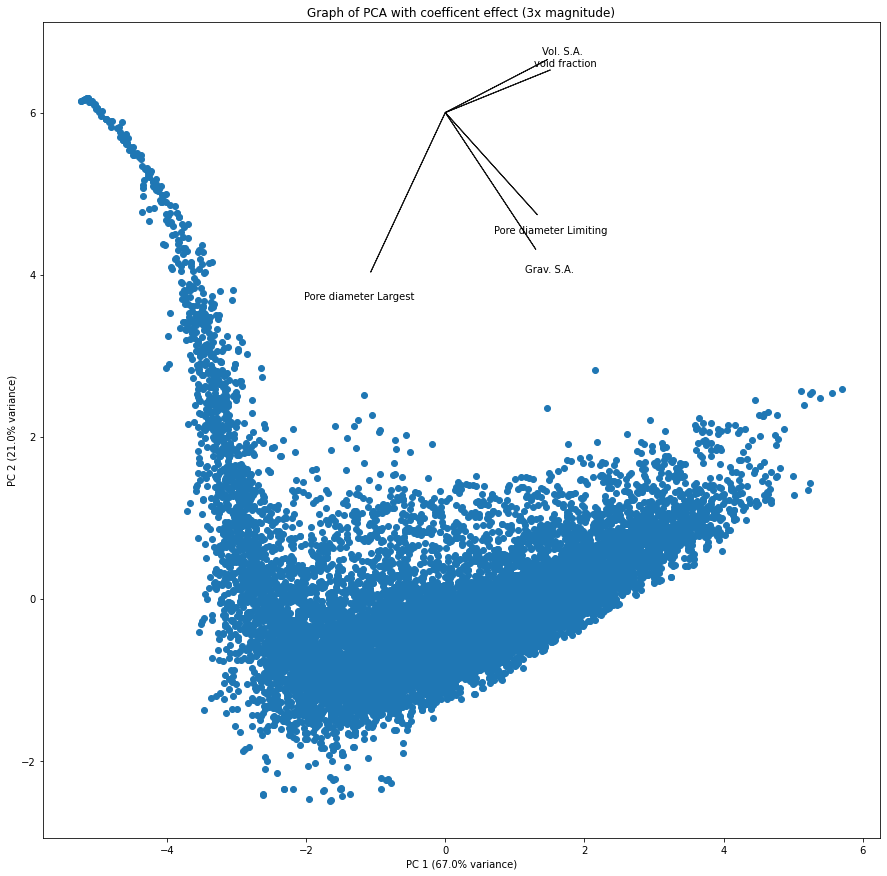

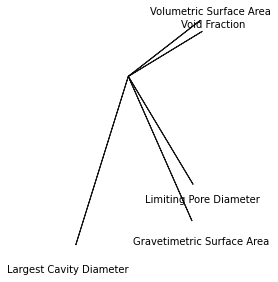

In [28]:
Out=PCA(n_components=2)
f=Out.fit(test)
a=f.transform(test)
pc1=a.T[:][0]
pc2=a.T[:][1]
plt.figure()
plt.scatter(pc1,pc2)
plt.title("Graph of PCA with coefficent effect (3x magnitude)")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
score=a[:,0:5]
coeff=np.transpose(f.components_[0:2, :])
y=test.columns
xs = score[:,0] # projection on PC1
ys = score[:,1] # projection on PC2
n = coeff.shape[0] # number of variables
classes = np.unique(y)
coeff=coeff*3
for i in range(n):
    #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
    plt.arrow(0, 6, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1, overhang=0.2)
    plt.text(coeff[i,0]* 1.15, 6+coeff[i,1] * 1.15, classes[i], color = 'k', ha = 'center', va = 'center',fontsize=10)
plt.gcf().set_size_inches(15, 15)
#plt.savefig("Bisect_plot.png",dpi=400)
plt.show()
score=a[:,0:5]
coeff=np.transpose(f.components_[0:2, :])
y=test.columns
xs = score[:,0] # projection on PC1
ys = score[:,1] # projection on PC2
n = coeff.shape[0] # number of variables
classes = ['Gravetimetric Surface Area', 'Largest Cavity Diameter', 'Limiting Pore Diameter','Volumetric Surface Area', 'Void Fraction']
coeff=coeff*3
for i in range(n):
    #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
    plt.arrow(0, 6, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1, overhang=0.2)
    plt.text(coeff[i,0]* 1.15, 6+coeff[i,1] * 1.15, classes[i], color = 'k', ha = 'center', va = 'center',fontsize=10)
plt.gcf().set_size_inches(4,4)
#plt.title("Bisect Plot (PCA feature direction)")
plt.tight_layout()
plt.axis('off')
plt.savefig("Bisect_plot_only.png",dpi=400)
plt.show()

In [30]:
Cluster_colors=[
"#009E73",
"#E69F00",
"#56B4E9",
"#F0E442",
"#D55E00",
"#CC79A7"]
def map_colors(df,colors):
    dic={}
    for i in df["Cluster"].unique():
        dic[i]=colors[i]
    df["color"]=df["Cluster"].map(dic)
    return df

### Generate Generic Clusters graph

5
4
3
2
1
0


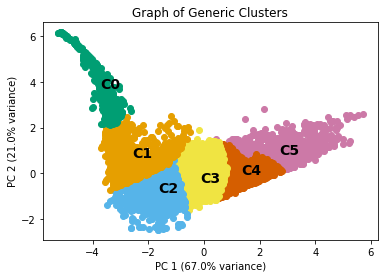

In [31]:
Out=PCA(n_components=2)
g=Out.fit(test)
data2=data.copy()
g_comp=6
holder=['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
for i in holder:
    temp=data2[holder]
    g=preprocessing.StandardScaler().fit_transform(temp)
    g=pd.DataFrame(g)
pc1,pc2,color=make_pca_agg_fit(1,g,var,g_comp,func_give=KMeans,array_out=True)
dic={
    "Pc1" : pc1,
    "Pc2" : pc2,
    "Cluster" : color,
}
holder=pd.DataFrame(dic)
data2=pd.concat([data2,holder],axis=1)
def manual_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y=0
    elif x == 2:
        y= 1
    elif x== 1:
        y=2
    elif x == 4:
        y=3
    elif x == 0:
        y=4
    else:
        y=5
    return y
data2["Cluster"]=data2["Cluster"].apply(manual_swap)
for i in range(5,-1,-1):
    print(i)
    t_1=data2[data2["Cluster"]==i]
    plt.scatter(t_1["Pc1"],t_1["Pc2"],color=Cluster_colors[i])
plt.title("Graph of Generic Clusters")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
abridge=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']]
new=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']].groupby("Cluster").mean()
#plt.scatter(new["Pc1"],new["Pc2"],c="r")
annotations=["C0","C1","C2","C3","C4","C5"]
for i, label in enumerate(annotations):
    plt.annotate(label, (new["Pc1"][i],new["Pc2"][i]),weight='bold',c="black",size=14)
plt.savefig("Generic_Cluster.png",dpi=400)

### Generate Generic Clusters graph versus preformance for each task CHECK COLORS

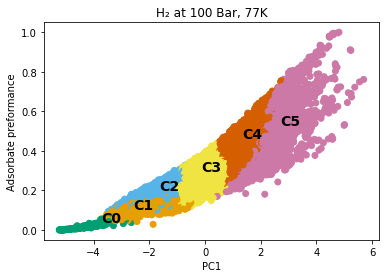

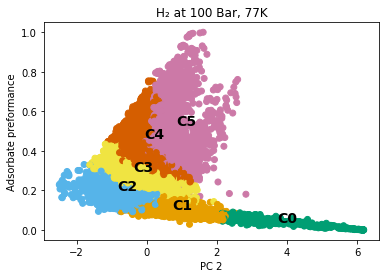

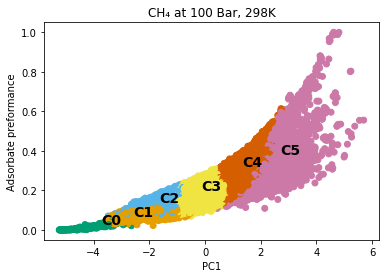

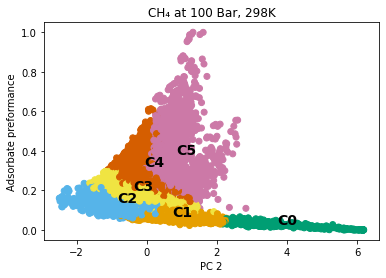

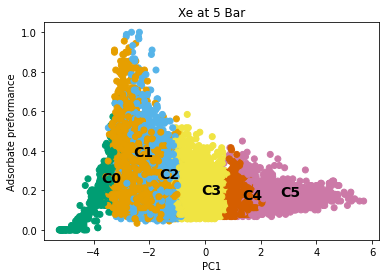

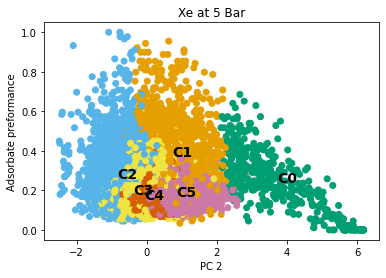

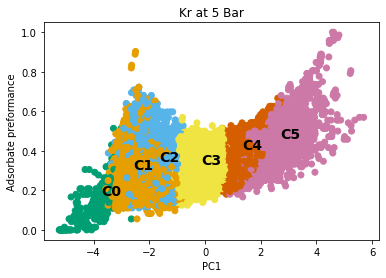

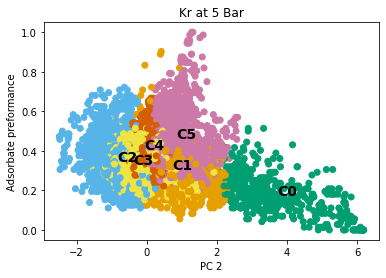

In [44]:
#color on 3 and 4 are opposite
from sklearn.preprocessing import MinMaxScaler
hold=pd.DataFrame()
#note H2 must be done manually bc will overwrite with this code
tasks=['H2@100 bar/77K (wt%)', 'CH4@100 bar/298 K (mg/g)', '5 bar Xe mol/kg', '5 bar Kr mol/kg']
names=[u'H\u2082 at 100 Bar, 77K',u'CH\u2084 at 100 Bar, 298K','Xe at 5 Bar','Kr at 5 Bar']
for count,i in enumerate(tasks):
    scaled=MinMaxScaler().fit_transform((data[i]).to_numpy().reshape(-1,1))
    hold[['Pc1', 'Pc2',"Cluster"]]=data2[['Pc1', 'Pc2',"Cluster"]]
    hold[i]=scaled
    new=hold.groupby("Cluster").mean()
    hold=(map_colors(hold,Cluster_colors))
    plt.title(f"{names[count]}")
    plt.xlabel(f"PC1")
    plt.ylabel(f"Adsorbate preformance")
    plt.scatter(pc1,scaled,color=hold["color"])
    annotations=["C0","C1","C2","C3","C4","C5"]
    for z, label in enumerate(annotations):
        plt.annotate(label, (new["Pc1"][z],new[i][z]),weight='bold',c="black",size=14)
    plt.savefig(f"Generic_{i[:7]}_PC1.png",dpi=400)
    plt.show()
    plt.title(f"{names[count]}")
    plt.xlabel(f"PC 2")
    plt.ylabel(f"Adsorbate preformance")
    plt.scatter(pc2,scaled,c=hold["color"])
    for z, label in enumerate(annotations):
        plt.annotate(label, (new["Pc2"][z],new[i][z]),weight='bold',c="black",size=14)
    plt.savefig(f"Generic_{i[:7]}_PC2.png",dpi=400)
    plt.show()

### Generate outline of PCA points (not used directly)

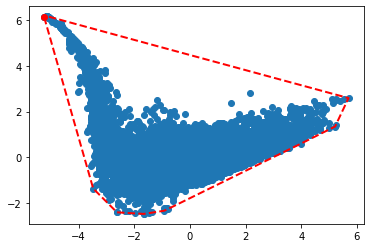

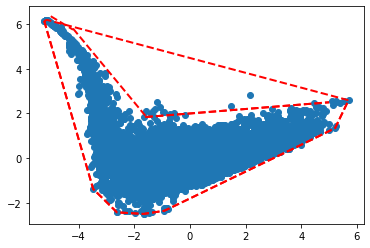

In [33]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
alpha_tuples=[[a,b] for a,b in zip(data2["Pc1"].to_numpy(),data2["Pc2"].to_numpy())]
alpha_tuples=np.array(alpha_tuples)
hull=ConvexHull(alpha_tuples)
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices[0],0], alpha_tuples[hull.vertices[0],1], 'ro')
plt.show()
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
x=np.linspace(-4.2,-1.6,1001)
y= lambda x: -.5 - 1.5*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-5,-4.2,1001)
y= lambda x: 2.6- .75*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)

### Generate pie charts of Clusters by topology (Not Used)

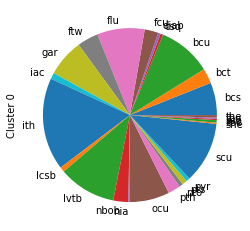

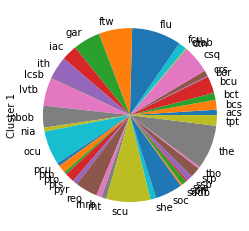

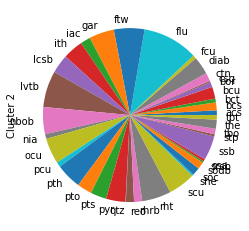

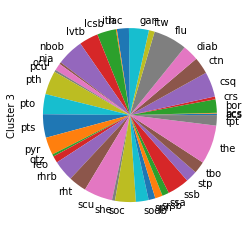

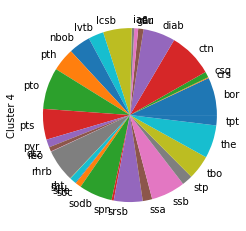

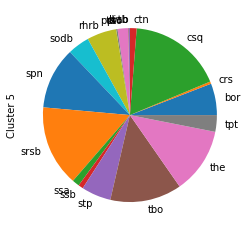

In [34]:
for i in range(6):
    abridge[f"Cluster {i}"]=abridge["MOF ID"]
    Cluster1=abridge[abridge["Cluster"]==i]
    Cluster1.groupby("topology").count()[f"Cluster {i}"].plot.pie(y=f"Cluser {i}")
    plt.show()

### Generate topology distributions by generic cluster

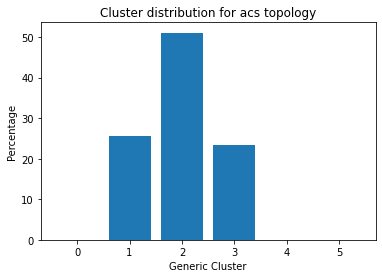

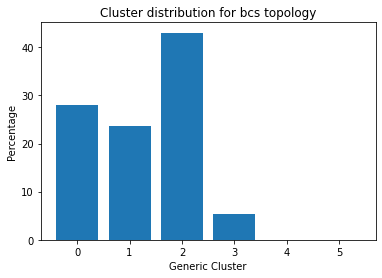

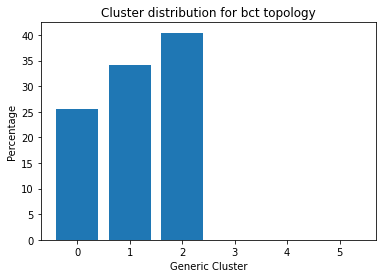

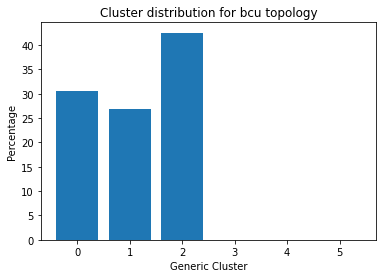

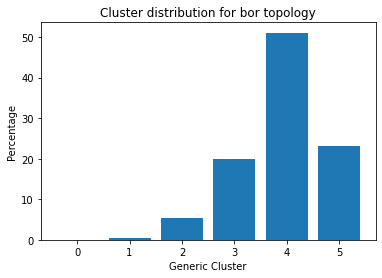

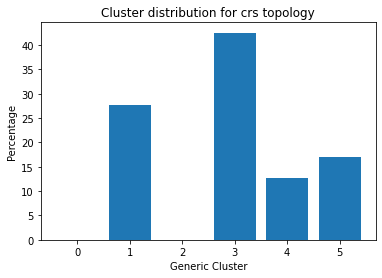

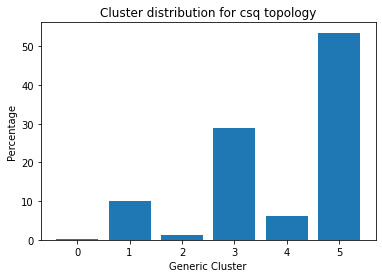

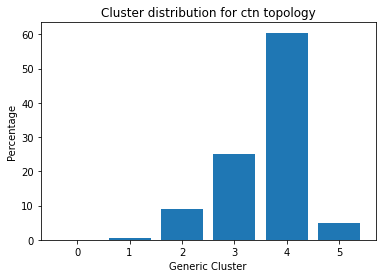

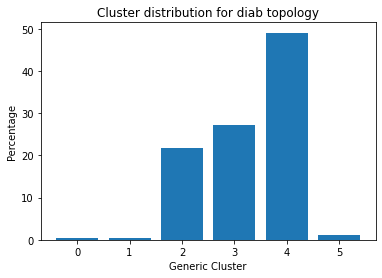

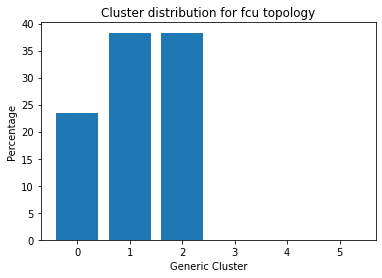

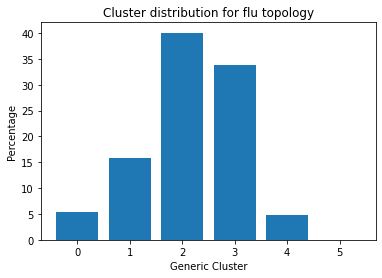

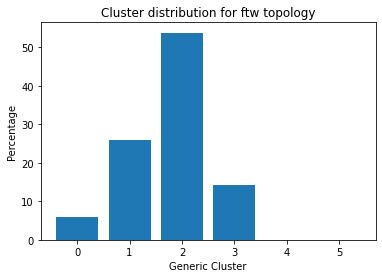

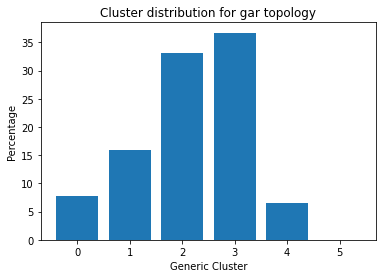

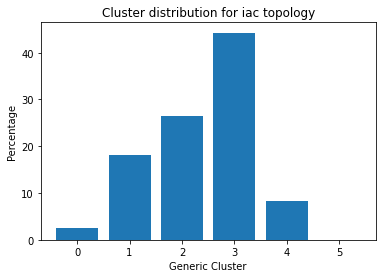

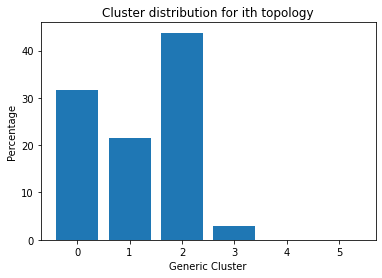

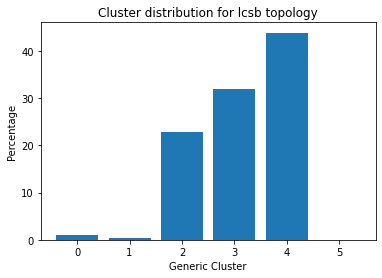

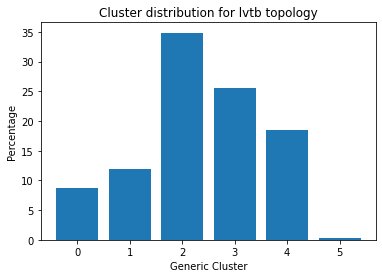

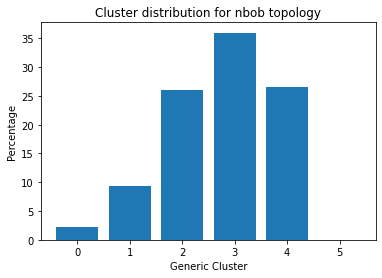

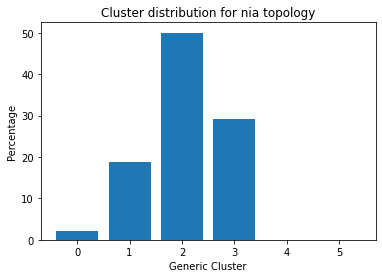

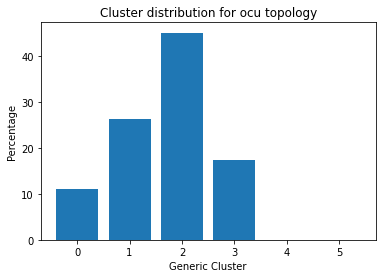

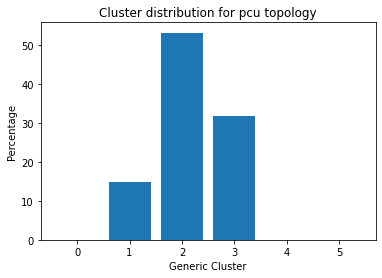

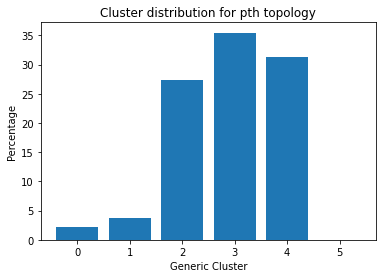

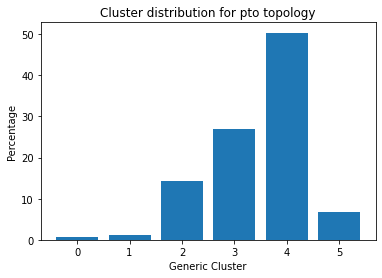

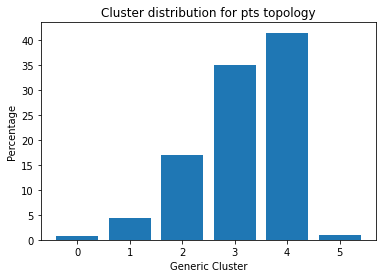

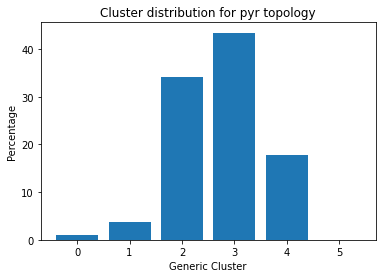

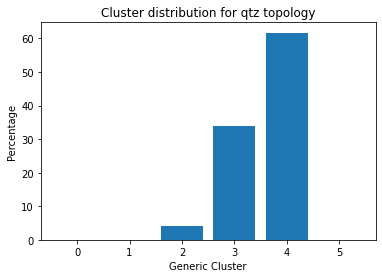

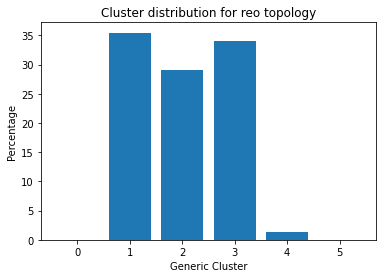

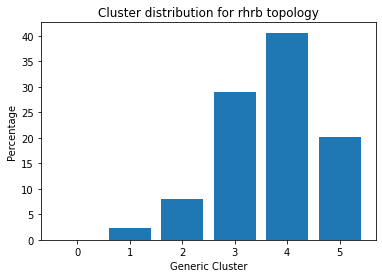

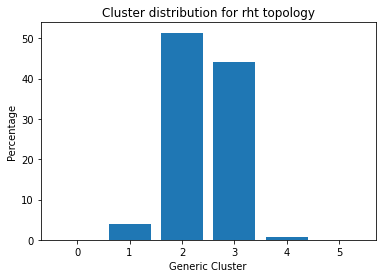

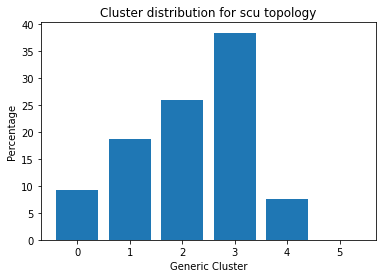

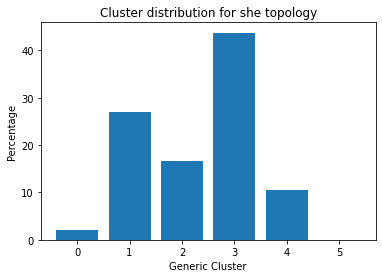

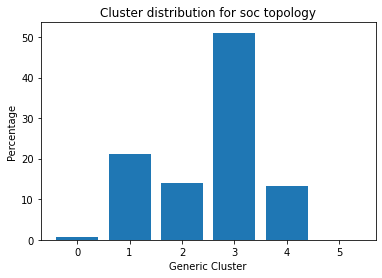

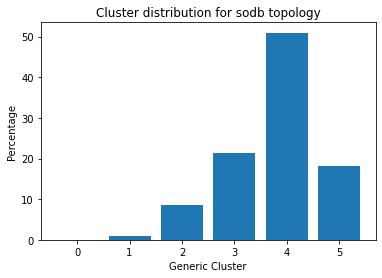

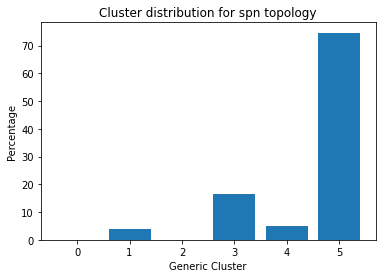

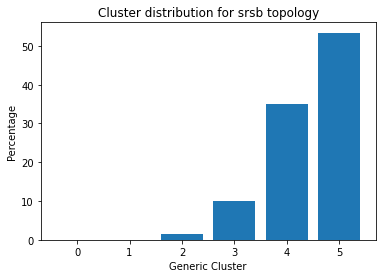

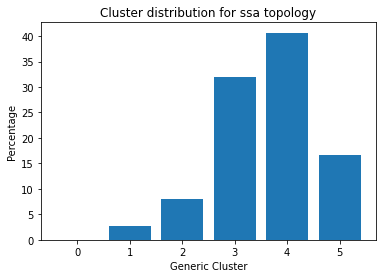

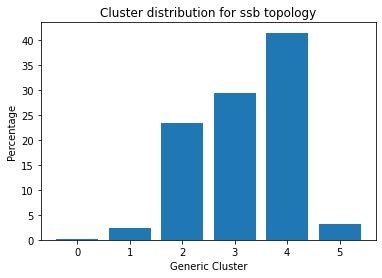

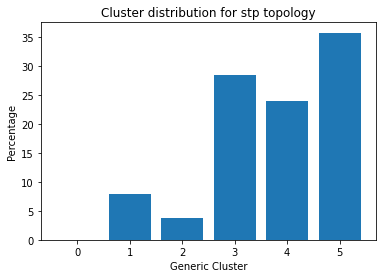

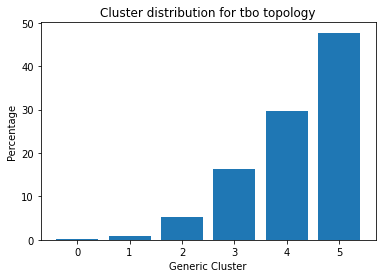

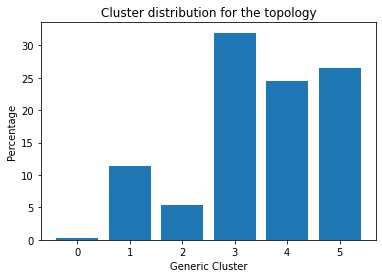

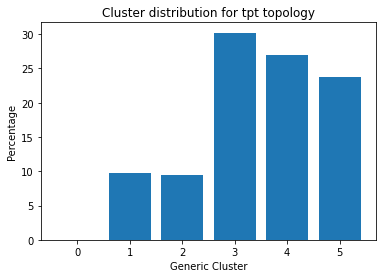

In [35]:
dic={}
for i in abridge["topology"].unique():
    dic[i]=[]
for i in range(6):
    Cluster1=abridge[abridge["Cluster"]==i]
    for j in abridge["topology"].unique():
        if sum(Cluster1["topology"]==j) > 0:
            dic[j].append(sum(Cluster1["topology"]==j))
        else:
            dic[j].append(0)
for i in dic:
    dic[i]=np.array(dic[i])
    dic[i]=(dic[i]/sum(dic[i]))*100
    plt.bar([0,1,2,3,4,5],dic[i])
    plt.title(f"Cluster distribution for {i} topology")
    plt.ylabel("Percentage")
    plt.xlabel("Generic Cluster")
    plt.savefig(f"topology_historgrams/{i}_distribution.png",dpi=400)
    plt.show()

### Generate relationship between Generic and Topology

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


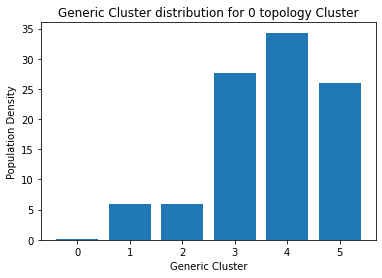

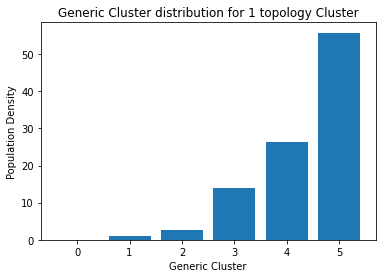

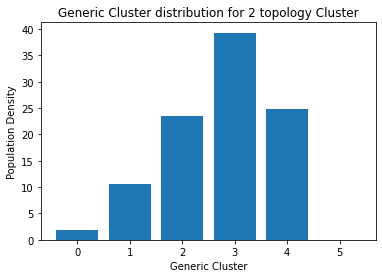

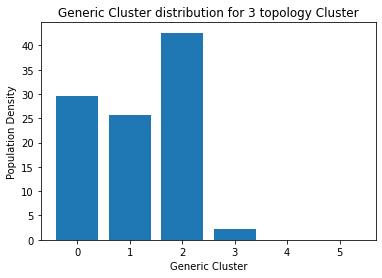

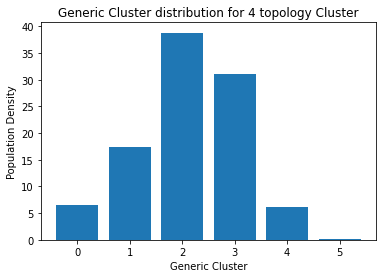

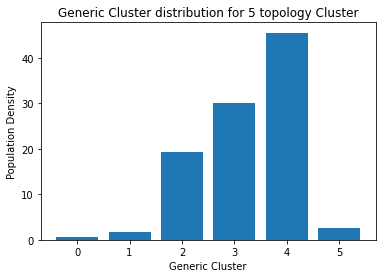

objc[63119]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59114550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11392c568). One of the two will be used. Which one is undefined.
[0110/121738.882024:INFO:headless_shell.cc(623)] Written to file /var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/tmphilqmtn4/temp.png.


In [36]:
import dataframe_image as dfi
map={
    
"Cluster 0":['tpt', 'crs', 'sodb', 'csq', 'bor', 'ctn', 'the', 'stp', 'rhrb', 'ssa'],

"Cluster 1":['srsb' ,'tbo' ,'spn'] ,

"Cluster 2":['soc' ,'pth' ,'pyr' 'iac', 'nbob', 'she'] ,

"Cluster 3":['bcs', 'ith', 'bcu', 'bct', 'fcu'] ,

"Cluster 4":['gar', 'flu', 'rht', 'nia', 'ftw', 'lvtb', 'ocu', 'scu', 'reo', 'pcu', 'acs'],

"Cluster 5":['pts', 'ssb', 'lcsb', 'pto', 'diab', 'qtz'] ,
}
large={}
for i in map:
    for g in map[i]:
        large[g]=i
        print(len(i))
abridge.groupby("topology").median()
abridge["topology_1"]=abridge["topology"].map(large)
frame={}
for xl in range(6):
    dic={}
    g=abridge[abridge["topology_1"]==f"Cluster {xl}"].groupby("Cluster")["MOF ID"].count()
    for i in range(6):
        if  i in g.keys():
            dic[i]=(g[i]/sum(g))*100
        else:
            dic[i]=0
    frame[xl]=dic
    plt.bar([0,1,2,3,4,5],[dic[i] for i in dic])
    plt.title(f"Generic Cluster distribution for {xl} topology Cluster")
    plt.ylabel("Population Density")
    plt.xlabel("Generic Cluster")
    plt.savefig(f"top_GC_relationship/{xl}_distribution.png",dpi=400)
    plt.show()

f=pd.DataFrame(frame).T
f.columns=["% Generic Cluster 0","% Generic Cluster 1","% Generic Cluster 2","% Generic Cluster 3","% Generic Cluster 4","% Generic Cluster 5"]
f.index.name="Topology Cluster"
f=f.round(2)
dfi.export(f, "top_GC_relationship/frame.png")

### Generate topology points on PCA outline

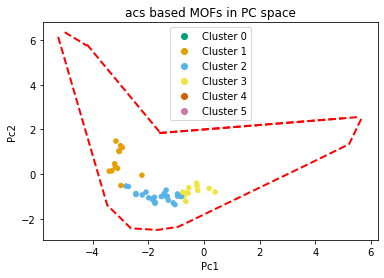

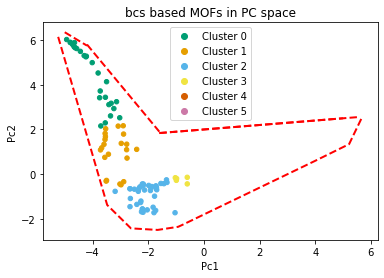

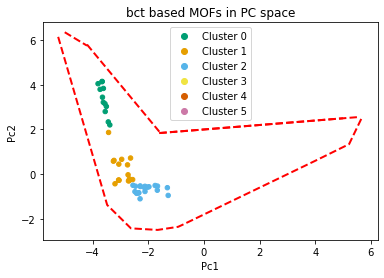

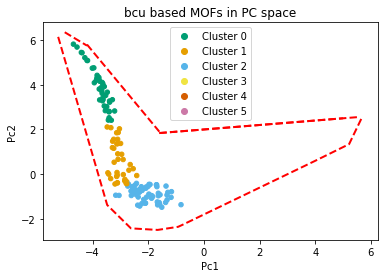

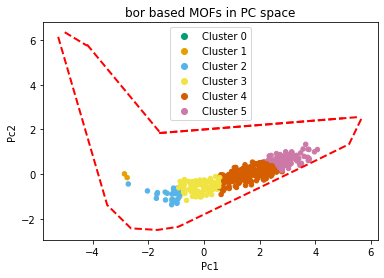

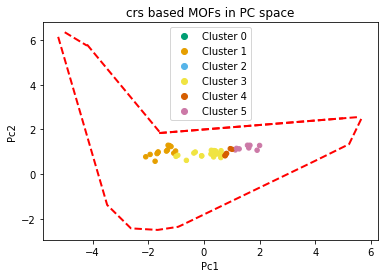

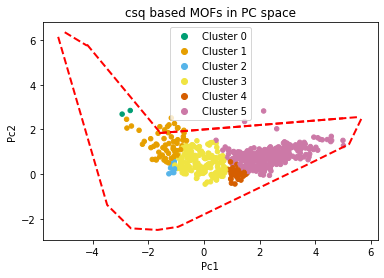

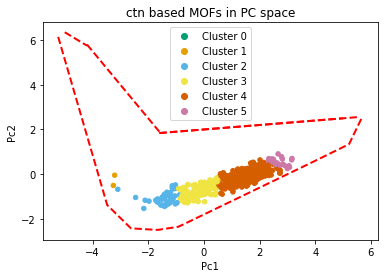

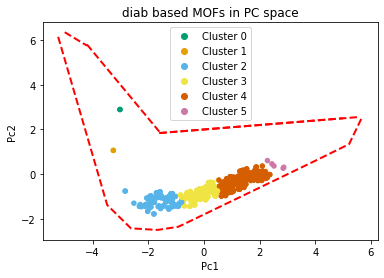

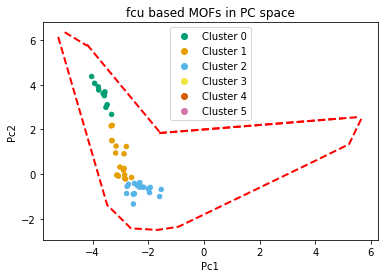

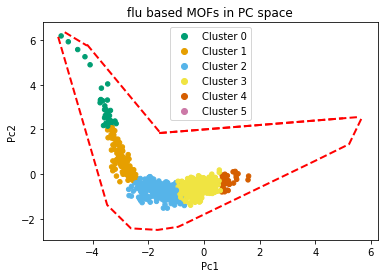

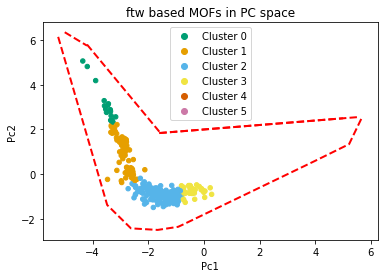

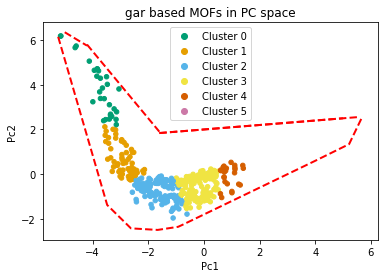

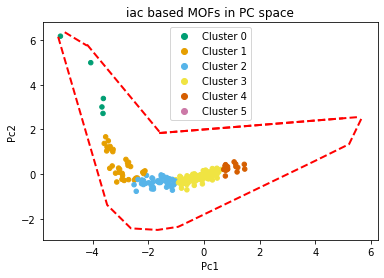

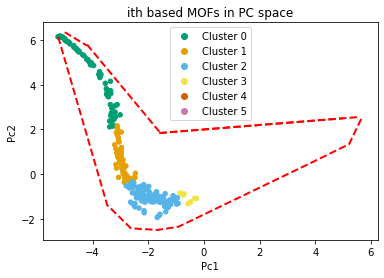

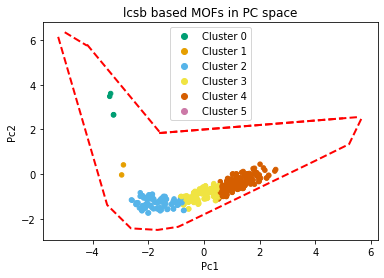

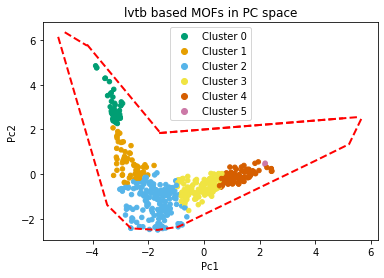

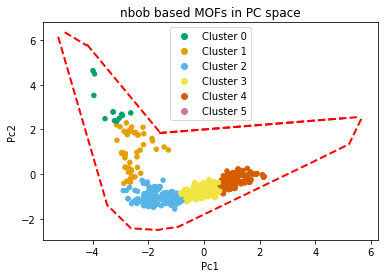

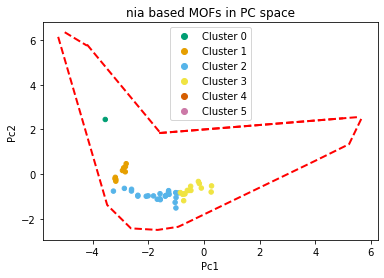

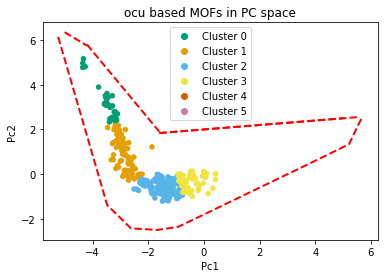

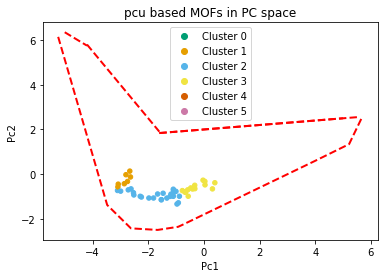

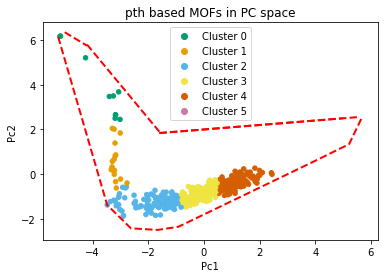

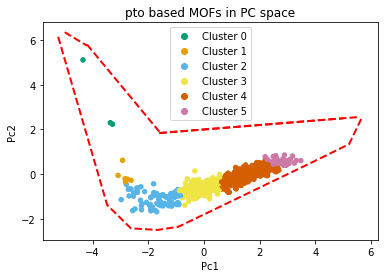

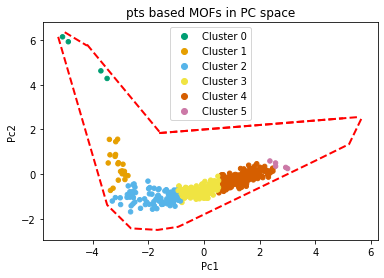

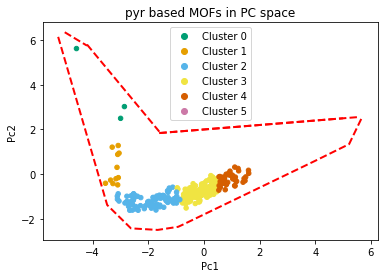

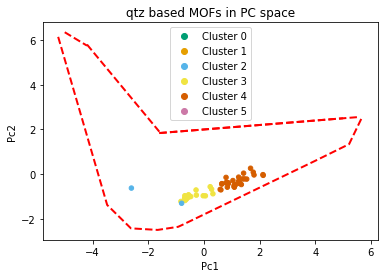

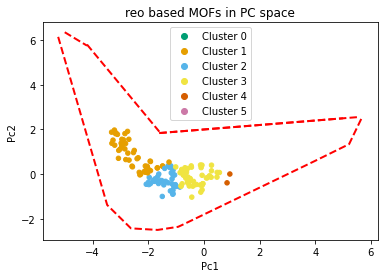

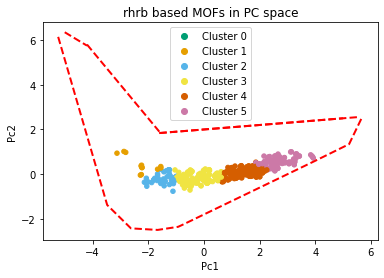

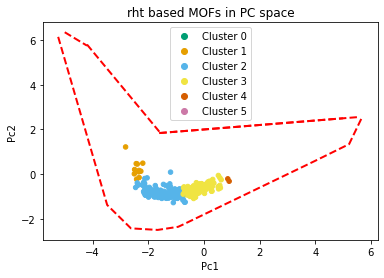

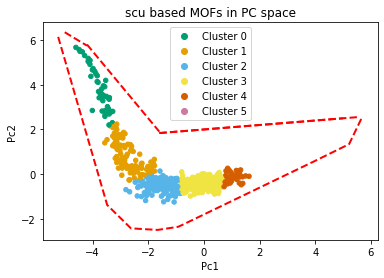

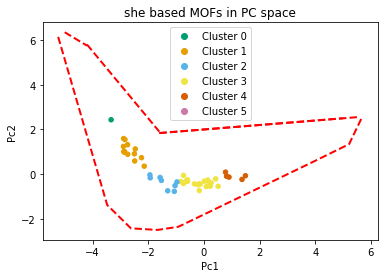

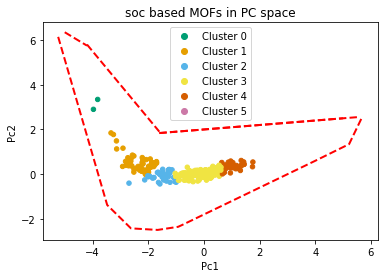

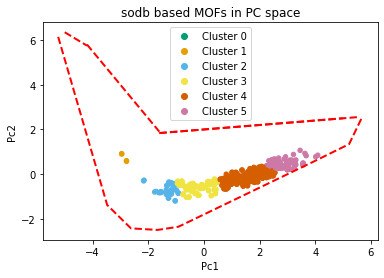

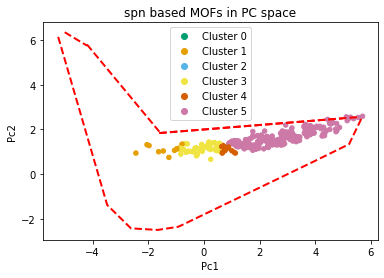

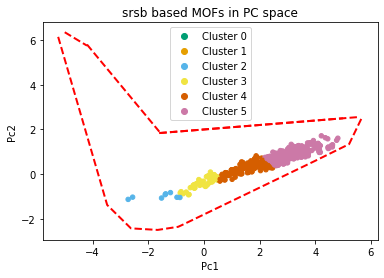

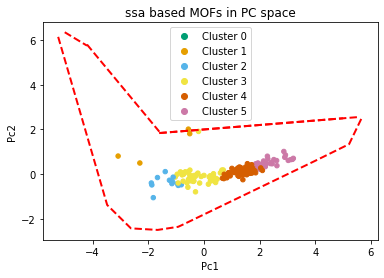

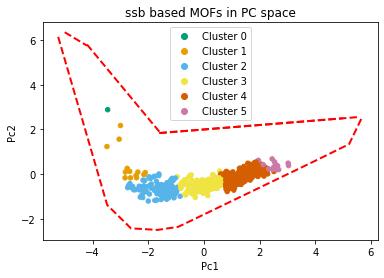

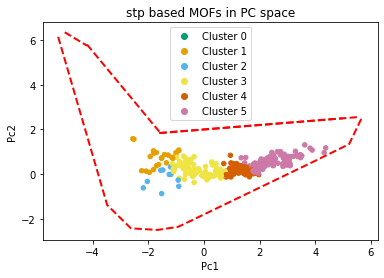

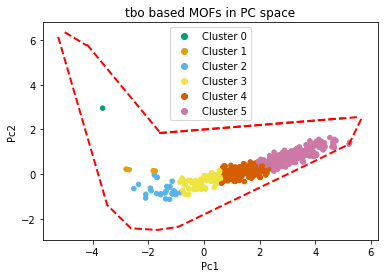

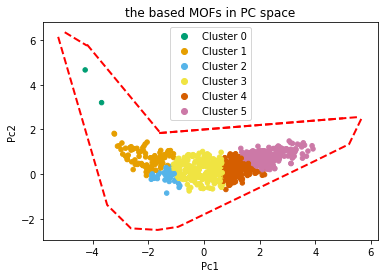

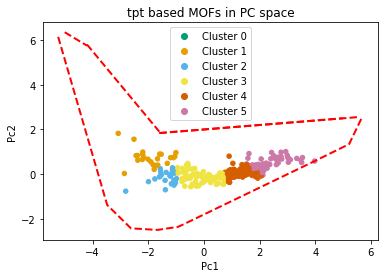

In [46]:
import matplotlib.lines as mlines
def color_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y="r"
    elif x == 2:
        y= "b"
    elif x== 1:
        y="g"
    elif x == 4:
        y= "y"
    elif x == 0:
        y= "m"
    else:
        y="c"
    return y
abridge=map_colors(abridge,Cluster_colors)
for i in (abridge["topology"].unique()):
    interest=i
    
    abridge[abridge["topology"]==interest][["Pc1","Pc2","Cluster"]].plot.scatter(x="Pc1",y="Pc2",c=abridge[abridge["topology"]==interest]["color"])
    annotations=["C0","C1","C2","C3","C4","C5"]
    c0 = mlines.Line2D([], [], color=Cluster_colors[0], marker='o', ls='', label='Cluster 0')
    c1 = mlines.Line2D([], [], color=Cluster_colors[1], marker='o', ls='', label='Cluster 1')
    c2 = mlines.Line2D([], [], color=Cluster_colors[2], marker='o', ls='', label='Cluster 2')
    c3 = mlines.Line2D([], [], color=Cluster_colors[3], marker='o', ls='', label='Cluster 3')
    c4 = mlines.Line2D([], [], color=Cluster_colors[4], marker='o', ls='', label='Cluster 4')
    c5 = mlines.Line2D([], [], color=Cluster_colors[5], marker='o', ls='', label='Cluster 5')
    plt.legend(handles=[c0,c1,c2,c3,c4,c5])
    #plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.title(f"{i} based MOFs in PC space")
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
    plt.savefig(f"topology_outline/{i}_cluster_out.png",dpi=400)

### Generate topology map by median or mean

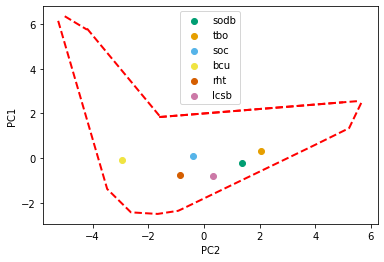

In [38]:
z=abridge.groupby(["topology"]).median()
interests=["sodb","tbo","soc","bcu","rht","lcsb"]
colors=[]
out={"Pc1":[],"Pc2":[]}
for count,i in enumerate(interests):
    a=z.loc[i]["Pc1"]
    b=z.loc[i]["Pc2"]
    plt.scatter(a,b,c=Cluster_colors[count],label=i)
    plt.legend()
    #plt.title(f"{i} points in PCA colored by cluster")
x=np.linspace(-4.2,-1.6,1001)
y= lambda x: -.5 - 1.5*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-5,-4.2,1001)
y= lambda x: 2.6- .75*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5.5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
#z.plot.scatter(x="Pc1",y="Pc2")
plt.ylabel("PC1")
plt.xlabel("PC2")
#plt.title("Topology Median points in PCA")
plt.savefig(f"Figure?.png",dpi=400)

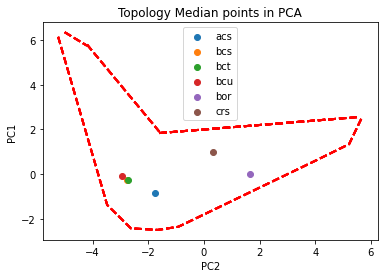

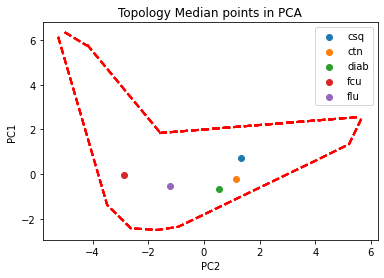

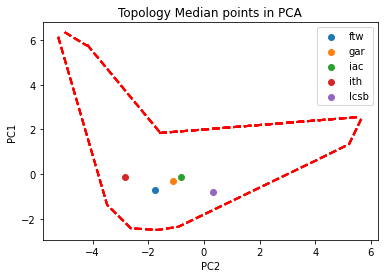

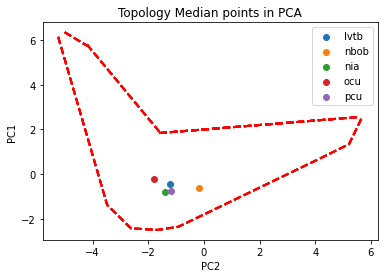

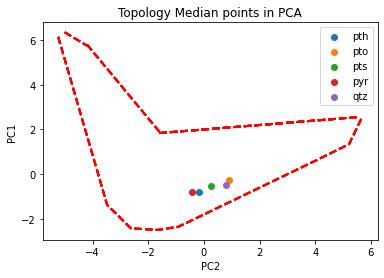

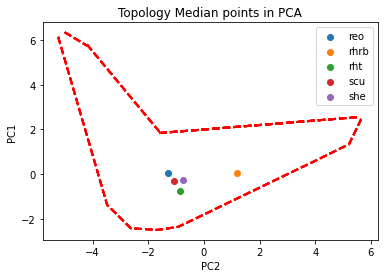

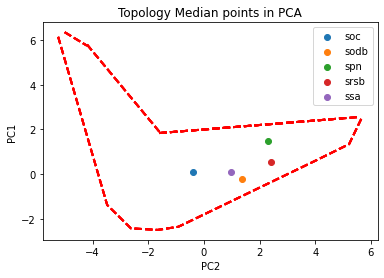

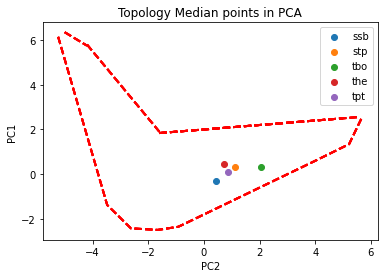

In [39]:
store=[]
median=True
for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    if median:
        abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median()
        a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median().to_numpy()
    if not median:
        abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean()
        a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean().to_numpy()
    plt.scatter(a,b,label=i)
    plt.legend()
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
    if (z % 5 ==0) and (z != 0 ):
        if median:
            plt.title("Topology Median points in PCA")
        else:
            plt.title("Topology mean points in PCA")
        plt.ylabel("PC1")
        plt.xlabel("PC2")
        loud=True
        if loud:
            if median:
                plt.savefig(f"Topology_median_{z}.png",dpi=400)
            else:
                plt.savefig(f"Topology_mean_{z}.png",dpi=400)
            plt.show()

### Color topology by generic cluster

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
1
2
3
4
5


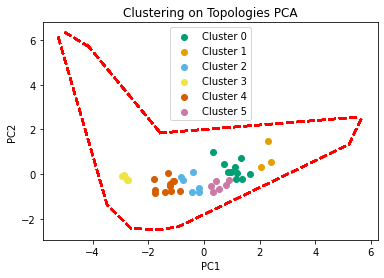

In [66]:

a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
a=a.sort_values(by="Pc1")
#plt.scatter(a["Pc1"],a["Pc2"])
color = AgglomerativeClustering(n_clusters=6).fit_predict(a[["Pc1","Pc2"]])
plt.legend()
distances=pd.DataFrame(distance_matrix(a,a),index=a.index,columns=a.index)
a["cluster"]=color
a["Hex_color"]=a["cluster"].apply(lambda x : Cluster_colors[x])
for i in sorted(a["cluster"].unique()):
    print(i)
    subset=a[a["cluster"] == i]
    plt.scatter(subset["Pc1"],subset["Pc2"],c=subset["Hex_color"][0],label=f"Cluster {i}")
plt.legend()
for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("Clustering on Topologies PCA")
plt.legend()
plt.savefig("Topology_clusters.png",dpi=400)
plt.show()

### Hierarchical clustering dendrogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


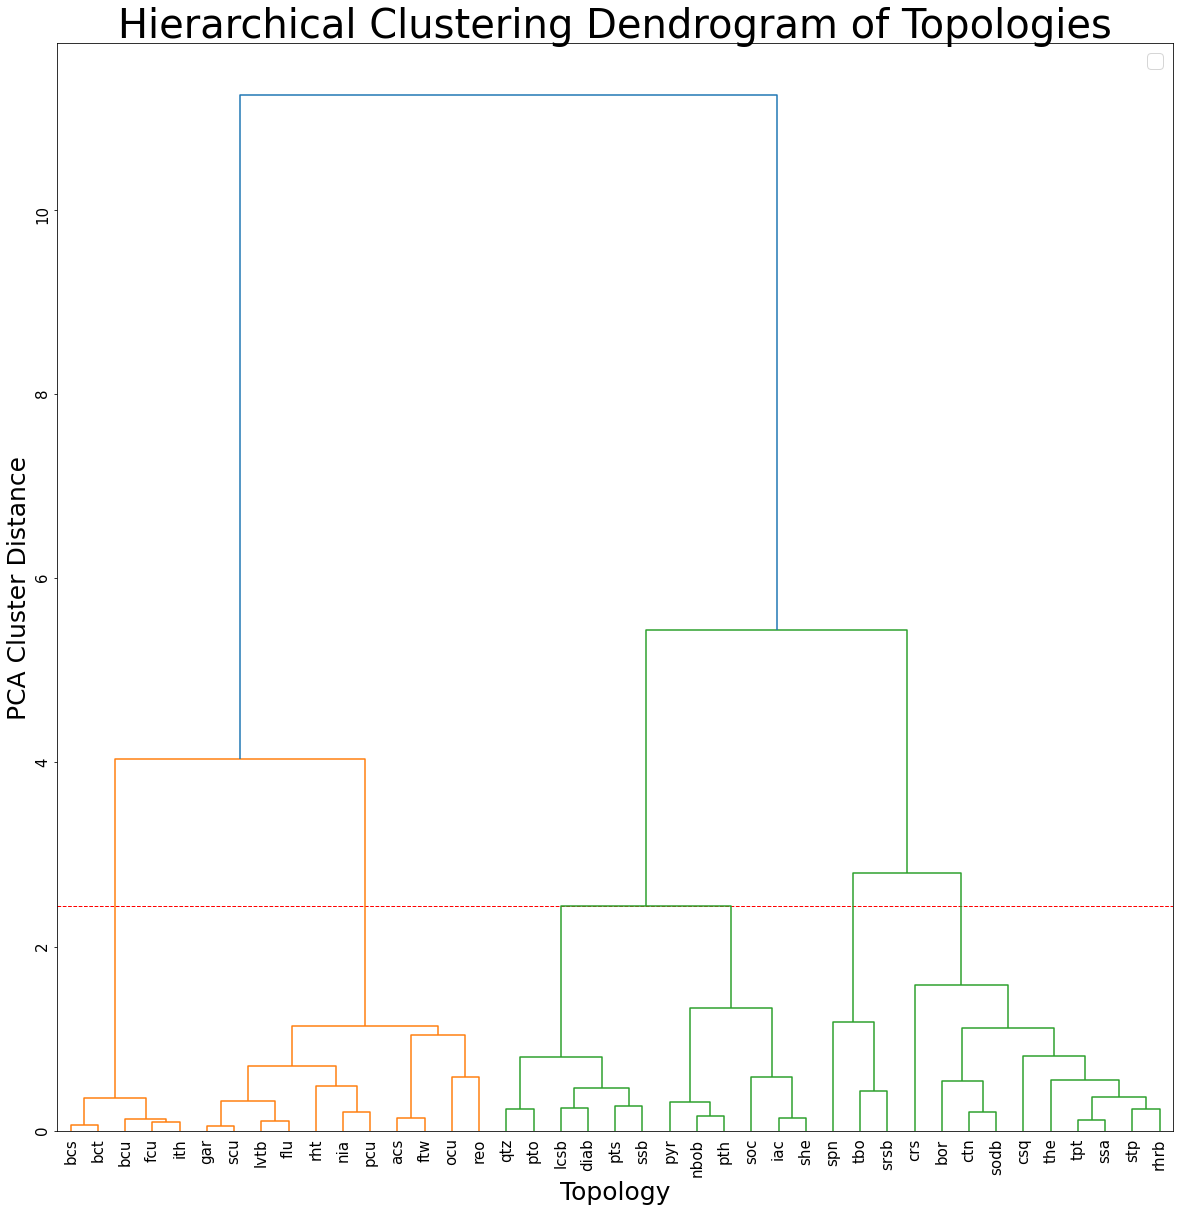

In [41]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                #print(i,merge,child_idx,current_count)
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    #dendrogram(linkage_matrix,link_color_func=color_den ,labels=a.index,orientation='top')
    dendrogram(linkage_matrix ,labels=a.index,orientation='top',no_labels=False)
    return


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(a)
    
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
plt.ylabel("PCA Cluster Distance",fontsize=25)
plt.xlabel("Topology",fontsize=25)
plt.title("Hierarchical Clustering Dendrogram of Topologies",fontsize=40)
plt.axhline(y=2.44, c='r', lw=1, linestyle='dashed')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.legend(fontsize=20)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15, rotation=90)
plt.savefig("Hierarchical.png",dpi=400)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


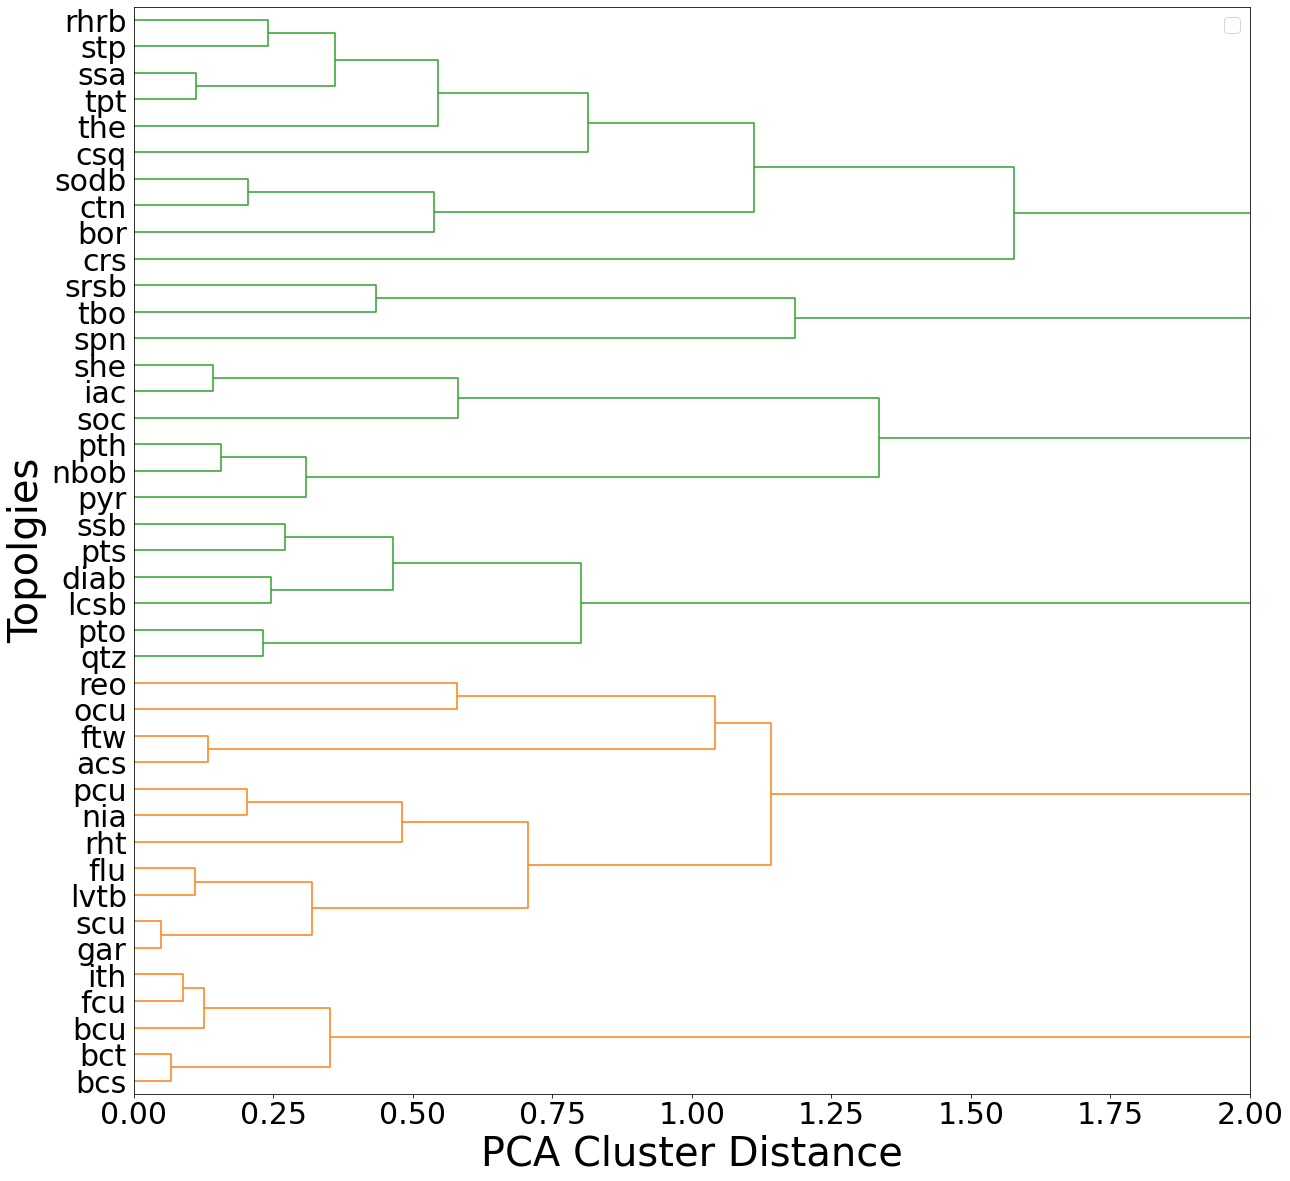

In [42]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                #print(i,merge,child_idx,current_count)
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    #dendrogram(linkage_matrix,link_color_func=color_den ,labels=a.index,orientation='top')
    dendrogram(linkage_matrix ,labels=a.index,orientation='right',no_labels=False)
    return


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(a)
    
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
plt.xlabel("PCA Cluster Distance",fontsize=40)
plt.ylabel("Topolgies",fontsize=40)
#plt.title("Hierarchical Clustering Dendrogram of Topologies",fontsize=40)
#plt.axhline(y=2.44, c='r', lw=1, linestyle='dashed')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlim(0,2)
plt.legend(fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("Hierarchical.png",dpi=400)